In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import sys
sys.path.insert(0, '../')
from utils.helper_functions import adf_check

In [2]:
df = pd.read_csv(r'../data/arima_data.csv', parse_dates=True, index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']
df.head()

,Value
1993-01,702157.6
1993-02,2726925.3
1993-03,4730318.6
1993-04,7378367.8
1993-05,11680753.4


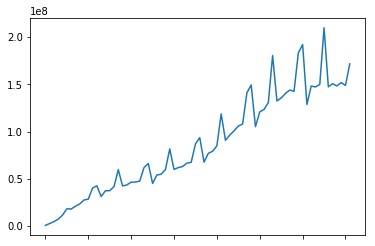

In [3]:
df.Value.plot()

## ARIMA Steps:
1. Make data stationary (differencing)
2. Fit AR model
3. Fit MA with residuals
4. Get back original
    * as we did differencing, we need to roll back to get original data range

### 1. Make Stationary

ADF Test Statistic : -5.225226609716361
p-value : 7.807176920051058e-06
Number of Lags Used : 3
Number of Observations Used : 55
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


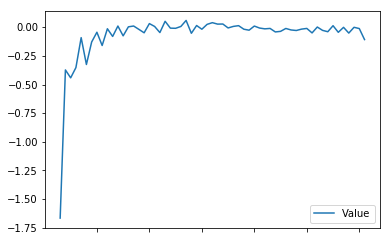

In [4]:
df_stationary = pd.DataFrame(np.log(df.Value).diff().diff(12))
adf_check(df_stationary.Value.dropna())

df_stationary.plot()

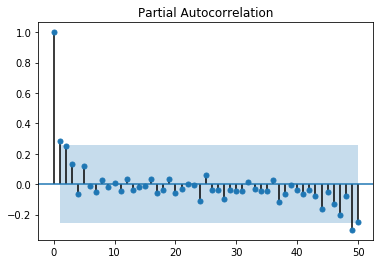

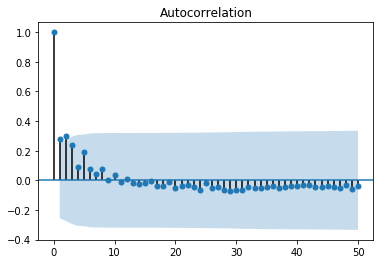

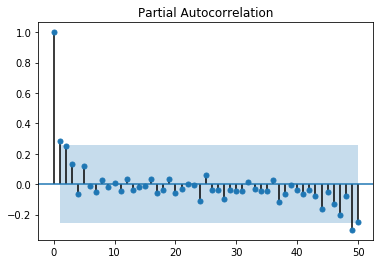

In [5]:
%matplotlib inline
plot_acf(df_stationary.dropna(),lags=50)
plot_pacf(df_stationary.dropna(),lags=50)

In [6]:
def AR(p,df):
  df_temp = df

  # Generating the lagged AR terms(p)
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)
    
  train_size = (int)(0.8 * df_temp.shape[0])

  # train test split
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  # dropna bcos of shift
  df_train_na = df_train.dropna()
  
  # X contains the lagged values ,hence we skip the first column
  X_train = df_train_na.iloc[:,1:].values.reshape(-1, p)
  #Y contains the value,it is the first column
  y_train = df_train_na.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_na['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_na,df_test,theta,intercept,RMSE]

In [7]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_na = res_train.dropna()
  X_train = res_train_na.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_na.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_na['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
#   res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_na,res_test,theta,intercept,RMSE]


### 2. Fit AR Model

The RMSE is : 0.033250097989191325 , Value of p :  2


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


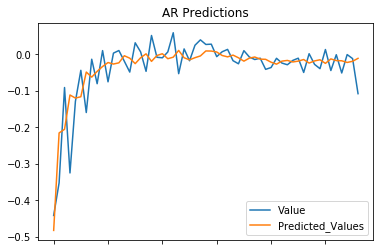

In [9]:
# AR Model
## sample order = 2
[df_train,df_test,theta,intercept,RMSE] = AR(2,pd.DataFrame(df_stationary.Value))

# concat data
ar_c = pd.concat([df_train,df_test])
ar_c[['Value','Predicted_Values']].plot(title = 'AR Predictions')

### 3. Fitting MA Model

The RMSE is : 0.03156167548599326 , Value of q :  2


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


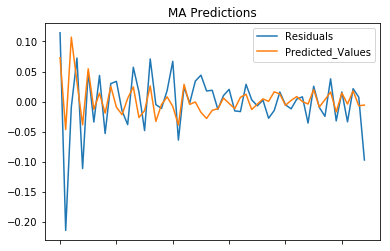

In [11]:
# Generate residuals for MA model
res = pd.DataFrame()
res['Residuals'] = ar_c.Value - ar_c.Predicted_Values

# MA Model
[res_train,res_test,theta,intercept,RMSE] = MA(2 ,pd.DataFrame(res.Residuals))

# concat data
ma_c = pd.concat([res_train, res_test])
ma_c[['Residuals','Predicted_Values']].plot(title = 'MA Predictions')

### 4. Bring back predictions

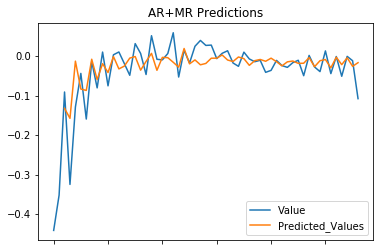

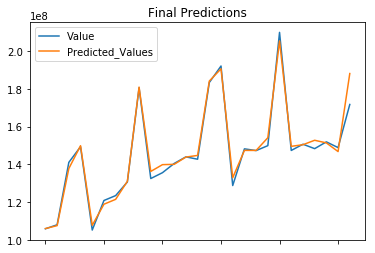

In [12]:
# AR + MA predictions
ar_c.Predicted_Values += ma_c.Predicted_Values
ar_c[['Value','Predicted_Values']].plot(title = 'AR+MR Predictions')

# getting back original data
# original value : np.log(df.Value).diff().diff(12)
ar_c.Value += np.log(df).shift(1).Value
ar_c.Value += np.log(df).diff().shift(12).Value
ar_c.Value = np.exp(ar_c.Value)

# predicted value
ar_c.Predicted_Values += np.log(df).shift(1).Value 
ar_c.Predicted_Values += np.log(df).diff().shift(12).Value
ar_c.Predicted_Values = np.exp(ar_c.Predicted_Values)

ar_c.iloc[30:,:][['Value','Predicted_Values']].plot(title = 'Final Predictions')